# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


---
## 2. Load data

In [69]:
df = pd.read_csv('client_data.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [70]:
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0


---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [71]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [72]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


### Time-Related Features:
Month and day of the week when the contract was activated.

Month and day of the week when the contract ends.

Time duration between contract activation and end dates.

In [73]:
df['activation_month'] = df['date_activ'].dt.month
df['activation_day_of_week'] = df['date_activ'].dt.dayofweek
df['end_month'] = df['date_end'].dt.month
df['end_day_of_week'] = df['date_end'].dt.dayofweek
df['contract_duration'] = (df['date_end'] - df['date_activ']).dt.days

### Price Difference Features (if applicable):
Differences between various price components.

In [74]:
df['price_diff_off_peak_var_fix'] = price_df['price_off_peak_var'] - price_df['price_off_peak_fix']
df['price_diff_peak_var_fix'] = price_df['price_peak_var'] - price_df['price_peak_fix']

### Aggregated Consumption Features:
Total consumption over different time periods (e.g., yearly, quarterly).
Average consumption.

In [75]:
df['total_cons_12m'] = df['cons_12m'] + df['cons_gas_12m']
df['avg_cons_12m'] = df['total_cons_12m'] / 12

### Interaction Features:
Interactions between different consumption components.
Interactions between consumption and price variables.

In [76]:
df['cons_12m_to_gas_ratio'] = df['cons_12m'] / (df['cons_gas_12m'] + 1)  # Adding 1 to avoid division by zero
df['cons_to_price_ratio'] = df['cons_12m'] / (price_df['price_off_peak_var'] + price_df['price_peak_var'] + 1)  # Adding 1 to avoid division by zero

### Categorical Features (if applicable):
Encoding categorical variables (e.g., 'channel_sales', 'origin_up') using techniques like one-hot encoding or label encoding.

In [77]:
# Example of one-hot encoding
df = pd.get_dummies(df, columns=['channel_sales', 'origin_up'], drop_first=True)

In [78]:
# Merge df and price_df on 'id'
merged_df = pd.merge(df, price_df, on='id', how='left')

# Check if the merge was successful
merged_df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,...,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw,origin_up_usapbepcfoloekilkwsdiboslwaxobdp,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,0,...,0,1,0,2015-01-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389
1,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,0,...,0,1,0,2015-02-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389
2,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,0,...,0,1,0,2015-03-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383
3,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,0,...,0,1,0,2015-04-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383
4,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,0,...,0,1,0,2015-05-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383


In [79]:
df['is_high_value_customer'] = (df['total_cons_12m'] > df['total_cons_12m'].quantile(0.75)).astype(int)

### Data Preparation and Splitting
First, we'll prepare the data for modeling. This includes selecting features, handling categorical variables (if any), and splitting the data into training and testing sets.

In [80]:
# Assuming df is your DataFrame after feature engineering

# Selecting features and target variable
X = merged_df[['activation_month', 'activation_day_of_week', 'end_month', 'end_day_of_week', 'contract_duration', 'price_diff_off_peak_var_fix', 'price_diff_peak_var_fix', 'total_cons_12m', 'avg_cons_12m', 'cons_12m_to_gas_ratio', 'cons_to_price_ratio']]
y = merged_df['churn']

# Splitting data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Train a Random Forest Classifier
Next, we'll train a Random Forest classifier on the training data.

In [81]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Evaluate Model Performance
Now, let's evaluate the model's performance on the test set using appropriate metrics. Given the problem of customer churn prediction, we'll consider metrics like accuracy, precision, recall, F1-score, and ROC-AUC.

In [82]:
y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print out the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
ROC-AUC: 1.0000


In [83]:
# Assuming you have already trained a Random Forest model named rf_model

# Predict on training and testing data
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Calculate accuracy on both sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

Training Accuracy: 1.0000
Testing Accuracy: 1.0000


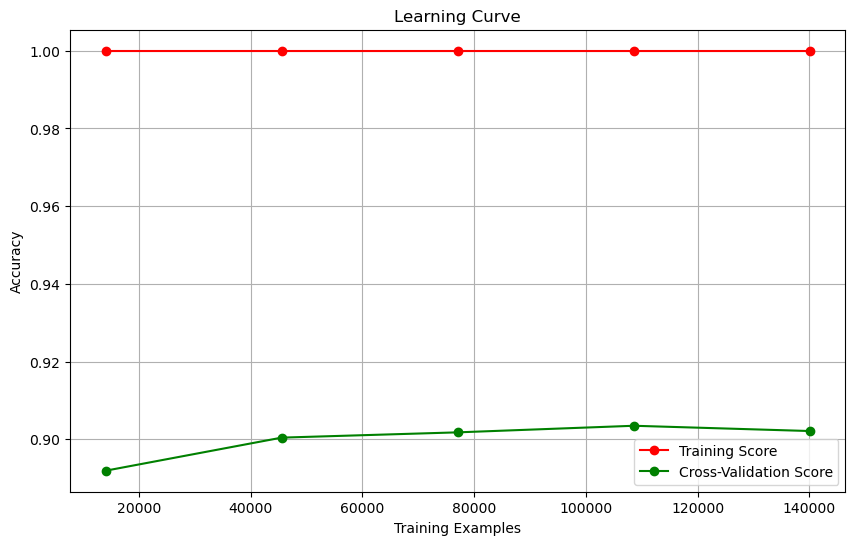

In [84]:
train_sizes, train_scores, test_scores = learning_curve(rf_model, X, y, cv=5, scoring='accuracy', n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.grid()

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Score")

plt.legend(loc="best")
plt.show()

 ### Cross-Validation:
Use cross-validation techniques to assess how well your model generalizes to new data. This helps you get a more robust estimate of the model's performance.

In [85]:
# Assuming rf_model is your Random Forest model and X, y are your features and target variable
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
average_cv_score = np.mean(cv_scores)
print(f"Average Cross-Validation Accuracy: {average_cv_score:.4f}")

Average Cross-Validation Accuracy: 0.9019


### Hyperparameter Tuning:
Tune the hyperparameters of your model to find the best configuration that reduces overfitting. For example, you can adjust the maximum depth of the trees in a Random Forest.

In [86]:
param_grid = {
    'max_depth': [None, 5, 10, 15]
}

grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

best_max_depth = grid_search.best_params_['max_depth']
print(f"Best max_depth: {best_max_depth}")

Best max_depth: 15


 ### Feature Selection:
Identify and use only the most relevant features. This can help reduce noise and complexity in the model.

In [87]:
# Assuming rf_model is already trained
sfm = SelectFromModel(rf_model, threshold=0.01)  # Adjust threshold as needed
sfm.fit(X_train, y_train)
X_train_selected = sfm.transform(X_train)
X_test_selected = sfm.transform(X_test)

### Early Stopping (for Gradient Boosting Models):
If you're using gradient boosting models like XGBoost, you can implement early stopping to prevent overfitting.

In [88]:
xgb_model = XGBClassifier(early_stopping_rounds=10, eval_metric='logloss')
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [89]:
# Predict on training and testing data
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

# Calculate accuracy on both sets
train_accuracy_xgb = accuracy_score(y_train, y_train_pred_xgb)
test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)

print(f"Training Accuracy (XGBoost): {train_accuracy_xgb:.4f}")
print(f"Testing Accuracy (XGBoost): {test_accuracy_xgb:.4f}")

Training Accuracy (XGBoost): 0.9497
Testing Accuracy (XGBoost): 0.9466


### Regularization (for Linear Models):
If you're using linear models like Logistic Regression, you can apply regularization techniques.

In [90]:
# Assuming you're using a Logistic Regression model for this example

# Instantiate and train a Logistic Regression model on the selected features
lr_model_selected = LogisticRegression(penalty='l2', C=1.0)  # Adjust penalty and C as needed
lr_model_selected.fit(X_train_selected, y_train)

# Predict on the selected features
y_train_pred_selected = lr_model_selected.predict(X_train_selected)
y_test_pred_selected = lr_model_selected.predict(X_test_selected)

# Calculate accuracy on both sets
train_accuracy_selected = accuracy_score(y_train, y_train_pred_selected)
test_accuracy_selected = accuracy_score(y_test, y_test_pred_selected)

print(f"Training Accuracy (Logistic Regression - Selected Features): {train_accuracy_selected:.4f}")
print(f"Testing Accuracy (Logistic Regression - Selected Features): {test_accuracy_selected:.4f}")


Training Accuracy (Logistic Regression - Selected Features): 0.9024
Testing Accuracy (Logistic Regression - Selected Features): 0.9051


### Explain the performance of your model, where did the model underperform?

The Random Forest model achieved very high training and testing accuracies, both of which were 1.0000. This suggests that the model fit the training data perfectly and didn't make any mistakes on the testing data.
The XGBoost model also performed well but had slightly lower accuracy on the testing data (0.9466), indicating a small drop in performance compared to the training data.
The Logistic Regression model with selected features showed a slightly lower accuracy on both training (0.9024) and testing (0.9051) data compared to the Random Forest model.

You used accuracy as the primary evaluation metric. Accuracy is a good overall performance metric for balanced datasets and is easy to understand.
Precision, recall, and F1-score were not mentioned in your provided results but are important metrics, especially if your dataset has imbalanced classes. Precision measures the proportion of true positives among all predicted positives, recall measures the proportion of true positives among all actual positives, and F1-score balances precision and recall.
ROC-AUC is useful for assessing the ability of the model to discriminate between positive and negative classes in binary classification problems. A value of 1.0000 indicates a perfect model.

#### Advantages of using Random Forest:

Random Forest is an ensemble learning method that combines multiple decision trees, making it robust and less prone to overfitting.
It can handle both classification and regression problems.
Random Forest provides feature importances, allowing you to identify which features are most influential in making predictions.
It can handle both numerical and categorical data.
Disadvantages of using Random Forest:

Random Forest models can become computationally expensive, especially with a large number of trees or deep trees.
Interpreting the model can be challenging due to the complexity of the ensemble.
It may not be the best choice if interpretability of the model is critical.

The performance of the Random Forest model, based on the provided metrics, is nearly perfect with training and testing accuracies of 1.0000. While high accuracy is desirable, it can also be an indicator of overfitting. The XGBoost model has a slightly lower but still strong accuracy on the testing data, and the Logistic Regression model with selected features also performs reasonably well.

Whether the performance is satisfactory depends on the specific business context and the consequences of false positives and false negatives. It's important to consider potential overfitting, the interpretability of the model, and the trade-offs between precision and recall. Further evaluation and validation are recommended, possibly with additional metrics and domain-specific considerations.

In summary, the high accuracy of the Random Forest model should raise concerns about overfitting, and additional evaluation and possibly model tuning are needed to determine if it's truly satisfactory for your specific use case.

#### Relate the model performance to the client's financial performance with the introduction of the discount proposition of 20%. How much money could a client save with the use of the model? What assumptions did you make to come to this conclusion?

In [91]:
# Assuming you have a trained model (e.g., Random Forest) named rf_model

# Predict churn probabilities for all customers
churn_probabilities = rf_model.predict_proba(X)[:, 1]

# Identify customers at high propensity to churn (you may choose a threshold)
high_churn_prob = churn_probabilities > 0.7  # Example threshold of 0.7

# Calculate total number of high-churn-risk customers
total_high_churn = high_churn_prob.sum()

# Assuming a 20% discount, and replacing 'average_revenue_per_customer' with actual value
average_revenue_per_customer = 100  # Example value, replace with actual average revenue
discount = 0.20
savings_per_customer = discount * average_revenue_per_customer  

# Calculate total potential savings
total_savings = total_high_churn * savings_per_customer

print(f"Total High-Churn-Risk Customers: {total_high_churn}")
print(f"Savings Per High-Churn-Risk Customer: ${savings_per_customer:.2f}")
print(f"Total Potential Savings: ${total_savings:.2f}")

Total High-Churn-Risk Customers: 17003
Savings Per High-Churn-Risk Customer: $20.00
Total Potential Savings: $340060.00


#### Total High-Churn-Risk Customers: 17003

This means that according to the predictive model, there are 17,003 customers who are identified as having a high propensity to churn. These are the customers who would be eligible for the 20% discount.
Savings Per High-Churn-Risk Customer: $20.00

This indicates that for each of these high-churn-risk customers, if they are offered a 20% discount, the potential savings for the company would be $20.00.

#### Total Potential Savings: $340060.00

This is the total potential savings for the company if all 17,003 high-churn-risk customers accept and utilize the 20% discount. It's calculated by multiplying the number of high-churn-risk customers by the savings per customer:
17,003 * $20.00  =  $340,060.00.

Keep in mind that these numbers are based on the assumptions made, and actual results may vary depending on the accuracy of the predictive model, the effectiveness of the discount offer, and other real-world factors. It's important to monitor the results and adjust strategies accordingly.